In [1]:
import sys
from torchsummary import summary
import functools
import ast
import torch
import random
import numpy as np
import icecream as ic
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
sys.path.append("../../")
sys.path.append("../")
####### Dataset ############
from data_processor import DataProcessor
######## Search space #########
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results, get_generation_dfs
######## Training ###############
from trainer import Trainer, TrainerDistillation
from utils.train_cfg import get_cfg, show_cfg
###################################################
random_seed = 1
random.seed(random_seed)
# Set seed for NumPy
np.random.seed(random_seed)
# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
# Additional steps if using CuDNN (optional, for GPU acceleration)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
from datetime import datetime
import itertools
import pandas as pd
import json
from io import StringIO
from coolname import generate_slug
from sklearn.metrics import accuracy_score
import torch.multiprocessing as mp

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dataset_metadata(dataset_path):
    with open(os.path.join(dataset_path, 'metadata'), "r") as f:
        metadata = json.load(f)
    return metadata
# load dataset from file
def load_datasets(data_path, truncate):
    data_path = '../../datasets/'+data_path
    train_x = np.load(os.path.join(data_path,'train_x.npy'))
    train_y = np.load(os.path.join(data_path,'train_y.npy'))
    valid_x = np.load(os.path.join(data_path,'valid_x.npy'))
    valid_y = np.load(os.path.join(data_path,'valid_y.npy'))
    test_x = np.load(os.path.join(data_path,'test_x.npy'))
    metadata = load_dataset_metadata(data_path)

    if truncate:
        train_x = train_x[:64]
        train_y = train_y[:64]
        valid_x = valid_x[:64]
        valid_y = valid_y[:64]
        test_x = test_x[:64]

    return (train_x, train_y), \
           (valid_x, valid_y), \
           (test_x), metadata

def validation(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 4. Calculate Accuracy
    accuracy = correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy * 100))

In [3]:
Dataset="CIFARTile"
(train_x, train_y), (valid_x, valid_y), (test_x), metadata = load_datasets(Dataset, truncate=False)
test_y = np.load(os.path.join('../../datasets/'+Dataset,'test_y.npy'))
metadata["select_augment"]=False
data_processor = DataProcessor(train_x[:], train_y[:], valid_x, valid_y, test_x, metadata)
train_loader, valid_loader, test_loader = data_processor.process()


metadata

/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
ic| self.x.shape: torch.Size([45000, 3, 64, 64])
ic| self.x.shape: torch.Size([15000, 3, 64, 64])
ic| self.x.shape: torch.Size([10000, 3, 64, 64])


{'num_classes': 4,
 'input_shape': [49260, 3, 64, 64],
 'codename': 'Caitie',
 'benchmark': 47.008,
 'select_augment': False,
 'train_config_path': 'anki_lab_submission/configs/train/augmentations_adam.yaml'}

In [4]:
current_transforms=train_loader.dataset.transform.transforms

In [5]:
from torchvision.transforms import v2
class RandomPixelChange:
    def __init__(self, change_prob=0.1):
        self.change_prob = change_prob
    
    def __call__(self, img):
        # Convert image to numpy array
        img_array = np.array(img).astype(np.float32)
        
        # Normalize the array to [0, 1]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())#
        
        unique_values=np.unique(img_array)
        
        # Generate a random mask with the same shape as img_array
        mask = np.random.rand(*img_array.shape) < self.change_prob
        
        # Apply the mask to randomly change the pixels to any of the unique values
        random_values = np.random.choice(unique_values, size=img_array.shape)
        img_array[mask] = random_values[mask]
        
        return img_array.transpose(1, 2, 0)

C,H,W=metadata['input_shape'][1:4]
PH,PW=int(H/8),int(W/8)
poss_augs= [               [],
                [RandomPixelChange(0.01), v2.ToTensor()],
                [RandomPixelChange(0.05), v2.ToTensor()],
                [RandomPixelChange(0.01), v2.ToTensor(), v2.RandomHorizontalFlip(),v2.RandomVerticalFlip()],
                [RandomPixelChange(0.01), v2.ToTensor(), v2.RandomCrop((H,W), padding=(PH,PW))],
                [v2.RandomHorizontalFlip(),v2.RandomVerticalFlip()],
                [v2.RandomErasing(p=0.2, scale=(0.05, 0.2), ratio=(0.3, 3.3))],
                [v2.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)), v2.RandomCrop((H,W), padding=(PH,PW))],
                [v2.RandomCrop((H,W), padding=(PH,PW))],
                [v2.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),v2.RandomCrop((H,W), padding=(PH,PW)),v2.RandomHorizontalFlip()]
           ]

poss_augs=   [             [],  # No augmentation

                [RandomPixelChange(0.02), v2.ToTensor()],
                [RandomPixelChange(0.05), v2.ToTensor()],
                [RandomPixelChange(0.01), v2.ToTensor(), v2.RandomHorizontalFlip(),v2.RandomVerticalFlip()],
                [RandomPixelChange(0.01), v2.ToTensor(), v2.RandomCrop((H,W), padding=(PH,PW))],

                [v2.RandomHorizontalFlip(), v2.RandomVerticalFlip()],
                [ v2.RandomCrop((H,W), padding=(PH,PW)),
                v2.RandomHorizontalFlip()],
                [v2.RandomGrayscale(p=0.2),v2.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3))],
                [ v2.RandomCrop((H,W), padding=(PH,PW)),
                v2.RandomHorizontalFlip(), v2.RandomGrayscale(p=0.1),v2.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3))]
                               ]


In [6]:
train_loader.shuffle=False

In [7]:
aug=7
train_loader.dataset.transform=v2.Compose(poss_augs[aug]+[current_transforms[-1]])


In [8]:
train_loader.dataset.transform.transforms

[RandomGrayscale(p=0.2),
 RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=[0.0], inplace=False),
 Normalize(mean=tensor([-0.2695, -0.2762, -0.2390]), std=tensor([1.1456, 1.1417, 1.0874]))]

In [9]:
#os.mkdir("zcost_proxies/results/augs")               
#df_syn.to_csv(f"zcost_proxies/results/augs/gutenberg_t{aug}.csv")

In [11]:
rg=RegNet(metadata,
                    W0=[16, 120, 8],
                    WA=[16, 64, 8],
                    WM=[2.05,2.9,0.05],
                    D=[8,22,1], 
                    G=[8,8,8], 
                    base_config=f"../configs/search_space/config.yaml")

In [12]:
current_time=datetime.now().strftime("%d_%m_%Y_%H_%M")
#folder=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool"
folder=f"/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train"

dataset=metadata["codename"]
#models, chromosomes=rg.load_generation(folder+"/"+dataset)
#models, chromosomes=rg.create_random_generation(save_folder=test_folder,gen=None, size=1, config_updates=None)

In [50]:
import json
with open(f'/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/augmentations_test/{dataset}/augmentation_results.json', 'r') as file:
    data = json.load(file)
    
val_scores_df=pd.DataFrame(data).T.sort_values(by="val_acc").reset_index().rename(columns={"index":"aug"})
val_scores_df.aug=val_scores_df.aug.astype(int)

aug_dfs=[]
for aug in [0,2,3,4,5,6,7,8]:
    df=pd.read_csv(f"zcost_proxies/results/augs/{dataset}_t{aug}.csv",index_col=0)[["fisher","grad_norm","jacob_cov","plain","snip","synflow"]].median().reset_index().set_index("index").T
    df["aug"]=aug
    aug_dfs.append(df)
aug_dfs=pd.concat(aug_dfs)

aug_merged=pd.merge(aug_dfs,val_scores_df[["aug","val_acc","train_acc"]],on="aug" ).sort_values(by="val_acc")

In [51]:
val_scores_df

,aug,val_acc,train_acc,epoch_time
0,1,26.500000,41.457443,30.256330
1,4,26.966667,50.643250,34.261710
2,2,29.106667,44.718216,30.842927
3,3,30.126667,44.037125,32.754755
4,0,46.806667,59.666576,9.626233
5,7,48.426666,61.433849,12.399353
6,5,58.466667,73.896011,12.167558
7,8,68.386665,70.136665,17.430750
8,6,69.053337,75.442932,15.319733


In [52]:
for metric in ["fisher","grad_norm","jacob_cov","plain","snip","synflow"]:
    print(metric)
    corr, _=spearmanr(aug_merged[metric],aug_merged["val_acc"])
    print(corr)

fisher
0.14285714285714288
grad_norm
0.4285714285714286
jacob_cov
0.0
plain
0.19047619047619052
snip
0.261904761904762
synflow
0.3233590907165799


In [53]:
aug_merged

,fisher,grad_norm,jacob_cov,plain,snip,synflow,aug,val_acc,train_acc
3,0.035559,20.254367,-129.006691,0.052259,80.543282,3.953281e+39,4,26.966667,50.643250
1,0.027626,19.811438,-128.941599,0.060183,72.616066,4.209597e+39,2,29.106667,44.718216
2,0.096594,33.491844,-128.995591,0.083029,155.533325,7.703862e+41,3,30.126667,44.037125
0,0.058657,33.105900,-129.009727,0.054275,159.422134,7.577779e+41,0,46.806667,59.666576
6,0.024783,20.433469,-128.994126,0.063075,83.771671,4.221342e+39,7,48.426666,61.433849
4,0.024656,19.721895,-128.978208,0.066911,79.816074,3.953281e+39,5,58.466667,73.896011
7,0.060178,33.147995,-129.002461,0.050118,152.232651,7.340520e+41,8,68.386665,70.136665
5,0.060679,33.594887,-128.997395,0.069126,153.365326,7.628238e+41,6,69.053337,75.442932


In [13]:
import json
import os

import kaleido
import pandas as pd
import numpy as np
import plotly.graph_objects as go
######## Search space #########
import sys
sys.path.append("../")
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results
# Initialize an empty list to store dictionaries
def results_to_df(path, name):
    data = []
    # Open the text file
    with open(path, 'r') as file:
        lines = file.readlines()
        # Initialize an empty dictionary to store data for each block
        block_data = {}
        for line in lines:
            # If the line contains dashes, it indicates the end of a block
            if '-------------------------' in line:
                # If block_data is not empty, add it to the list of data dictionaries
                if block_data:
                    data.append(block_data)
                    # Reset block_data for the next block
                    block_data = {}
            elif 'best_acc' in line:
                continue
            else:
                # Split the line by ':'
                #print(line)
                key, value = line.strip().split(': ')
                # Store the key-value pair in the block_data dictionary
                block_data[key] = value

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    # Convert columns to appropriate data types if needed
    df['epoch'] = df['epoch'].astype(int)
    df['lr'] = df['lr'].astype(float)
    df['train_acc'] = df['train_acc'].astype(float)
    df['train_loss'] = df['train_loss'].astype(float)
    df['test_acc'] = df['test_acc'].astype(float)
    df['test_acc_top5'] = df['test_acc_top5'].astype(float)
    df['test_loss'] = df['test_loss'].astype(float)
    df['epoch_time'] = df['epoch_time'].astype(float)
    df=df.assign(name=name)
    
    return df

metadata_dict={}
metadata_dict["Caitie"]={'num_classes': 4,
                         'input_shape': [49260, 3, 64, 64],
                         'codename': 'Caitie',
                         'benchmark': 47.008,
                         }
metadata_dict["Adaline"]={'num_classes': 20,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Adaline',
                         'benchmark': 89.85}
metadata_dict["Chester"]={'input_shape': [49998, 12, 8, 8],
                         'codename': 'Chester',
                         'benchmark': 57.826,
                         'num_classes': 3}
metadata_dict["Gutenberg"]={'input_shape': [45000, 1, 27, 18],
                         'codename': 'Gutenberg',
                         'benchmark': 40.98,
                         'num_classes': 6}
metadata_dict["LaMelo"]={'num_classes': 10,
                         'codename': 'LaMelo',
                         'input_shape': [50000, 1, 24, 24],
                         'benchmark': 85.2}
metadata_dict["Mateo"]={'num_classes': 10,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Mateo',
                         'benchmark': 90.87}
metadata_dict["Sadie"]={'input_shape': [50000, 3, 64, 64],
                         'codename': 'Sadie',
                         'benchmark': 80.33,
                         'num_classes': 10}
metadata_dict["Sokoto"]={'input_shape': [50000, 1, 9, 9],
                         'codename': 'Sokoto',
                         'benchmark': 0.0,
                         'num_classes': 9}
def get_predictor_data_from_folder(base_folder,studies):

    
    train_data=[]
    for study_name in studies: 
        

        metadata=metadata_dict[study_name]
        rg=RegNet(metadata,
                        W0=[16, 120, 8],
                        WA=[16, 64, 8],
                        WM=[2.05,2.9,0.05],
                        D=[8,22,1], 
                        G=[8,8,8], 
                        base_config=f"../configs/search_space/config.yaml")
        data=[]
        study_folder=f"{base_folder}/{study_name}"
        subjects= os.listdir(study_folder)

        subjects=[subject for subject in subjects if os.path.isdir(f"{study_folder}/{subject}")]
        print(subjects)
        for name in subjects:
            try:
                test_acc=results_to_df(f"{study_folder}/{name}/worklog.txt", f"{name}")[["epoch","test_acc","name"]]
                #test_acc=test_acc.rename(columns={"test_acc":"acc","test_loss":"test_acc"})
                #print(test_acc.columns)
                if len(test_acc)>49:
                    test_acc_piv = test_acc[["epoch","test_acc","name"]].pivot(index='name', columns='epoch', values='test_acc').add_prefix("epoch_").reset_index()
                    test_acc_piv["best_acc"]=test_acc["test_acc"].max()
                    
                    model, info=rg.load_model(config_file=f"{study_folder}/{name}/config.yaml")
                    test_acc_piv["gen"]=1
                    test_acc_piv["num_stages"]=info["num_stages"]
                    test_acc_piv["params"]=info["params"]
                    test_acc_piv["WA"]=info["WA"]
                    test_acc_piv["W0"]=info["W0"]
                    test_acc_piv["WM"]=info["WM"]
                    test_acc_piv["DEPTH"]=info["DEPTH"]
                    test_acc_piv["num_classes"]=metadata["num_classes"]
                    test_acc_piv["num_channels"]=metadata["input_shape"][1]
                    test_acc_piv["benchmark"]=metadata["benchmark"]
                    
                    #print(info)
                    data.append(test_acc_piv)
            except:
                    pass

        data=pd.concat(data)
        train_data.append(data)
    train_data=pd.concat(train_data)
    return train_data
    

In [15]:
train_data=get_predictor_data_from_folder(base_folder=folder,
                                          studies=[dataset])
#test_data=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train",
#                                         studies=test_studies)

['masked_earthworm', 'daffy_mongrel', 'wandering_tody', 'uber_bat', 'vivacious_eel', 'lush_chimpanzee', 'ultra_vulture', 'olive_hoatzin', 'antique_taipan', 'tremendous_pony', 'independent_chowchow', 'micro_pug', 'cerulean_galago', 'capable_mussel', 'fuzzy_magpie', 'magic_pheasant', 'charming_dachshund', 'invisible_stork', 'sapphire_seagull', 'axiomatic_vole', 'snobbish_curassow', 'vengeful_otter', 'ochre_grebe', 'imposing_walrus', 'lurking_chowchow', 'holistic_marten', 'spectral_flamingo', 'ruddy_rhino', 'aboriginal_okapi', 'slick_penguin', 'imperial_oyster', 'cherry_rook', 'adept_sponge', 'adaptable_weasel', 'loyal_macaque', 'amber_jackdaw', 'polar_harrier', 'giga_seal', 'calculating_coyote', 'gabby_kangaroo', 'manipulative_cormorant', 'steady_kakapo', 'obedient_curassow', 'cooperative_tench', 'prudent_caribou', 'radiant_raptor', 'impressive_agouti', 'placid_peacock', 'rose_mackerel', 'glittering_wildcat', 'inventive_horse', 'devious_cicada', 'delicate_lemur', 'certain_mastodon', 'abi

In [16]:
test_names=train_data.name.unique()[:]

In [17]:
len(valid_loader)

118

In [18]:
import torch.nn as nn
import types
import copy
import torch.nn.functional as F
from zcost_proxies.predictive import find_measures

In [19]:
metadata

{'num_classes': 4,
 'input_shape': [49260, 3, 64, 64],
 'codename': 'Caitie',
 'benchmark': 47.008,
 'select_augment': False,
 'train_config_path': 'anki_lab_submission/configs/train/augmentations_adam.yaml'}

In [20]:
from torch.utils.data import DataLoader, TensorDataset
train_loader_iter = iter(train_loader)

# Number of batches to extract
num_batches =1

# Initialize lists to hold the inputs and targets from the first 5 batches
inputs_list = []
targets_list = []

for _ in range(num_batches):
    inputs, targets = next(train_loader_iter)  # Get the next batch
    inputs_list.append(inputs)
    targets_list.append(targets)

# Concatenate the inputs and targets across the batches
inputs = torch.cat(inputs_list)
targets = torch.cat(targets_list)

# Create a new TensorDataset from the selected data
new_dataset = TensorDataset(inputs, targets)

# Create a new DataLoader from this new dataset
new_valid_loader = DataLoader(new_dataset, batch_size=train_loader.batch_size, shuffle=True)
#train_loader.batch_size

In [21]:
# Number of batches to extract
num_batches =5

# Initialize lists to hold the inputs and targets from the first 5 batches
inputs_list = []
targets_list = []

for _ in range(num_batches):
    inputs, targets = next(train_loader_iter)  # Get the next batch
    inputs_list.append(inputs)
    targets_list.append(targets)

# Concatenate the inputs and targets across the batches
inputs = torch.cat(inputs_list)
targets = torch.cat(targets_list)

# Create a new TensorDataset from the selected data
new_dataset = TensorDataset(inputs, targets)

# Create a new DataLoader from this new dataset
new_valid_loader_grasp = DataLoader(new_dataset, batch_size=train_loader.batch_size, shuffle=True)
#train_loader.batch_size


In [23]:
del train_loader
del valid_loader

In [24]:
def load_stages_pool(pool_folders):
    df_results_list=[]
    for pool_folder in pool_folders:
        df_results=pd.read_csv(f"{pool_folder}/df_blocks_pool.csv", index_col=0)
        df_results=df_results[df_results.dataset!=metadata["codename"]]
        df_results["dataset"]=pool_folder+df_results["dataset"]
        df_results_list.append(df_results)
    df_results=pd.concat(df_results_list)
    #df_results.to_csv("initial_pool.csv")
    return df_results

def transfer_weights(model,model_name,total_pool_individuals,rg):
        n_access={}

        print("Model Name: ",model_name)
        print("#######################")
        pool_models={}
        pool_chroms={}
        for stage, info in total_pool_individuals[model_name].items():
            name, transfer_dataset=info

            weights_file=f"{transfer_dataset}/{name}/student_best"
            config_file=f"{transfer_dataset}/{name}/config.yaml"
            if os.path.exists(weights_file):
                pool_models[stage],pool_chroms[stage]=rg.load_model(config_file=config_file, weights_file=weights_file)
            else:
                ic(f"Weights file does not exits {weights_file}")
                pool_chroms[stage]=None
        chrom=chromosomes[model_name]
        n_access[model_name]=0
        for stage in range(1,chrom["num_stages"]+1):
            if pool_chroms[stage] is not None:
                max_block=min(chrom["ds"][stage-1], pool_chroms[stage]["ds"][stage-1])
                print("###### MAX BLOCK #####: ",max_block)
                for block in range(1,max_block+1):
                    print("Block: ", block)
                    model_part = eval(f"model.s{stage}.b{block}")
                    orig_part = eval(f"pool_models[stage].s{stage}.b{block}.state_dict()")

                    for key in model_part.state_dict().keys():

                        tensor = orig_part[key]
                        tensor_shape = tensor.shape

                        tensor_student_shape=model_part.state_dict()[key].shape
                        if tensor_shape==tensor_student_shape:
                            #print(key)
                            #print(tensor_shape)
                            n_access[model_name]=n_access[model_name]+1


                            keys = key.split('.')

                            # Access the specific layer that contains the weight attribute
                            param = functools.reduce(getattr, keys[:-1], model_part)
                            #print(param.requires_grad)
                            #param.weight.requires_grad=False
                            # Use setattr to update the .data attribute of the weight tensor
                            getattr(param, keys[-1]).data = tensor.clone()
            else:
                ic(f"Stage {stage} is None")
        print(n_access)    
        rg=RegNet(metadata,
                        W0=[16, 120, 8],
                        WA=[16, 64, 8],
                        WM=[2.05,2.9,0.05],
                        D=[8,22,1], 
                        G=[8,8,8], 
                        base_config=f"../configs/search_space/config.yaml")
        return model

preloaded=False
if preloaded:
    pool_stages_df=load_stages_pool(
            #pool_folders= ["/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/"]
            pool_folders= ["/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool/"])
            #]) if self.pretrained_pool else pd.DataFrame()
        

    df_models=pd.DataFrame(chromosomes).T[["ws","ds","num_stages", "DEPTH"]]
    total_pool_individuals={}

    for model_name in list(chromosomes.keys()):
        df_current_model=df_models.loc[model_name]

        filtered_dfs=[]
        df_results_aux=pool_stages_df.drop(columns=["ws","ds"])
        df_results_aux["diff_stages"]=abs(df_results_aux["num_stages"]-df_current_model["num_stages"])
        df_results_aux["diff_depth"]=abs(df_results_aux["DEPTH"]-df_current_model["DEPTH"])

        for stage in range(1, df_current_model["num_stages"]+1):
            df_results_aux[f"diff_ws{stage}"]=abs(df_results_aux[f"ws{stage}"]-df_current_model["ws"][stage-1])
            df_results_aux[f"diff_d{stage}"]=abs(df_results_aux[f"ds{stage}"]-df_current_model["ds"][stage-1])

        for stage in range(1, df_current_model["num_stages"]+1):
            if stage==1:
                df_results_aux=df_results_aux.sort_values(["diff_ws1","diff_d1","diff_stages","diff_ws2","diff_depth"])
            else:
                df_results_aux=df_results_aux.sort_values([f"diff_ws{stage}",f"diff_d{stage}",f"diff_ws{stage-1}","diff_stages", "diff_depth"])

            if stage==1:
                first_row_values = df_results_aux[["diff_stages", f"diff_ws{stage}", f"diff_d{stage}"]].iloc[0]
                # Filter the DataFrame based on these values
                filtered_df = df_results_aux[
                    (df_results_aux["diff_stages"] == first_row_values["diff_stages"]) &
                    (df_results_aux[f"diff_ws{stage}"] == first_row_values[f"diff_ws{stage}"]) &
                    (df_results_aux[f"diff_d{stage}"] == first_row_values[f"diff_d{stage}"])
                ]
            else:
                first_row_values = df_results_aux[["diff_stages",f"diff_ws{stage-1}", f"diff_ws{stage}", f"diff_d{stage}"]].iloc[0]
                # Filter the DataFrame based on these values
                filtered_df = df_results_aux[
                    (df_results_aux["diff_stages"] == first_row_values["diff_stages"]) &
                    (df_results_aux[f"diff_ws{stage-1}"] == first_row_values[f"diff_ws{stage-1}"]) &
                    (df_results_aux[f"diff_ws{stage}"] == first_row_values[f"diff_ws{stage}"]) &
                    (df_results_aux[f"diff_d{stage}"] == first_row_values[f"diff_d{stage}"])
                ]
            filtered_dfs.append(filtered_df)

        pool_individuals={}
        items=[]
        for idx, stage_df in enumerate(filtered_dfs):
            items.append(dict(zip(stage_df.index.tolist(),stage_df.dataset.tolist())))
        for idx, item in enumerate(items):
            for i in range(0,len(items)):
                if i !=idx:
                    common_items = item.items() & items[i].items()
                    #print(common_items)
                    if common_items:
                        pool_individuals[idx+1]=next(iter(common_items))
                        break
            if idx+1 not in pool_individuals:
                 pool_individuals[idx+1]=next(iter(item.items()))
        total_pool_individuals[model_name]=pool_individuals  


In [25]:
#del models
import gc
gc.collect()

0

In [27]:
import gc
individuals=os.listdir(folder+"/"+dataset)
individuals=[ind for ind in individuals if os.path.isdir(os.path.join(folder+"/"+dataset, ind)) and ".ipynb" not in ind]
#individuals = random.sample(individuals, 20)
individuals=['invisible_stork',
 'flying_tody',
 'honest_sloth',
 'happy_hedgehog',
 'daffodil_mackerel',
 'antique_taipan',
 'adept_sponge',
 'magic_pheasant',
 'emerald_earthworm',
 'fiery_heron',
 'lyrical_skylark',
 'ingenious_puffin',
 'rose_mackerel',
 'asparagus_mammoth',
 'spectral_flamingo',
 'cerulean_galago',
 'impressive_binturong',
 'uber_bat',
 'cherry_mastiff',
 'divergent_mole']
syn_scores={}
measures=["fisher","grad_norm","jacob_cov","plain","snip","synflow"]
for individual in individuals:
                gc.collect
                ind_config=f"{folder}/{dataset}/{individual}/config.yaml"
                
                model_aux, _=rg.load_model(config_file=ind_config)
                if preloaded:
                    model_aux=transfer_weights(model_aux,individual,total_pool_individuals,rg)
                syn_scores[individual]=find_measures(model_aux.to("cuda"), new_valid_loader, ("random",len(new_valid_loader),metadata["num_classes"]), "cuda", F.cross_entropy, measures )
                
                syn_scores[individual]["grasp"]=find_measures(model_aux.to("cuda"), new_valid_loader_grasp, ("grasp",len(new_valid_loader_grasp),metadata["num_classes"]), "cuda", F.cross_entropy, ["grasp"] )["grasp"]
                del model_aux
                gc.collect


Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/invisible_stork/config.yaml


/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0/lib/python3.12/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/flying_tody/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/honest_sloth/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/happy_hedgehog/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/daffodil_mackerel/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/antique_taipan/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/adept_sponge/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/magic_pheasant/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train/Caitie/emerald_earthworm/config.yaml
Loading model: /home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifi

In [29]:
df_syn=pd.DataFrame(syn_scores).T.reset_index().rename(columns={"index":"name"})

In [33]:
sorted_df=train_data[train_data.name.isin(test_names)].sort_values(by="best_acc",ascending=False)[["name","best_acc"]]
df_syn=pd.merge(df_syn, sorted_df[["name","best_acc"]], on="name")
df_syn=df_syn.sort_values(by="best_acc",ascending=False)

In [34]:
for metric in ["grasp","fisher","grad_norm","jacob_cov","plain","snip","synflow"]:
    if metric=="jacob_cov":
        df_syn[f"rank_{metric}"]=df_syn[metric].rank(ascending=False).astype(int)
    else:
        df_syn[f"rank_{metric}"]=df_syn[metric].rank().astype(int)

In [35]:
df_syn.head(10)[["rank_jacob_cov","rank_snip","rank_grad_norm"]].sum(axis=1).rank(ascending=True).astype(int)

0      8
13    10
1      9
5      1
17     6
11     4
18     3
12     7
10     4
16     2
dtype: int64

In [36]:
df_syn.head(10)

,name,fisher,grad_norm,jacob_cov,plain,snip,synflow,grasp,best_acc,rank_grasp,rank_fisher,rank_grad_norm,rank_jacob_cov,rank_plain,rank_snip,rank_synflow
0,invisible_stork,0.339233,84.290810,-128.997664,0.485008,471.623199,7.658091e+53,452.466675,90.55,17,17,18,11,20,18,15
13,asparagus_mammoth,4.807892,236.178848,-129.032097,-0.341567,1393.496948,7.809049e+64,15839.566406,88.02,20,20,20,15,1,20,20
1,flying_tody,0.374094,74.006508,-129.038862,0.219872,461.849274,7.738844e+44,-31.790359,87.58,5,18,17,17,17,17,13
5,antique_taipan,0.010136,10.139218,-128.965507,-0.000652,54.411110,1.008409e+27,-11.496610,86.85,11,3,2,7,2,7,4
17,uber_bat,0.054573,25.989874,-129.037391,0.036742,152.927353,2.622048e+41,23.206848,86.51,14,14,12,16,8,15,12
11,ingenious_puffin,0.027172,27.886860,-128.882305,0.192485,91.771538,2.301706e+59,-33.630600,86.19,3,11,13,2,16,12,18
18,cherry_mastiff,0.019817,19.738598,-128.940606,0.112149,83.040024,2.789768e+33,-25.957006,85.60,7,9,10,5,13,10,8
12,rose_mackerel,0.281642,72.945198,-129.014253,0.060319,339.011383,2.533506e+57,850.405762,85.51,18,16,16,13,10,16,17
10,lyrical_skylark,0.011243,13.250108,-129.025070,0.057316,54.345139,7.102761e+31,-2.796352,85.42,12,6,7,14,9,6,7
16,impressive_binturong,0.012378,13.206054,-128.944454,0.026935,58.651211,2.892519e+29,-17.254631,84.69,9,7,6,6,7,8,5


In [37]:
from scipy.stats import spearmanr
dict_spearman={}
dict_pearson={}
for metric in ["grasp","fisher","grad_norm","jacob_cov","plain","snip","synflow"]:
#for metric in ["snip"]:
        spearman_corr, _ = spearmanr(df_syn['best_acc'],df_syn[f"{metric}"])
        pearson_corr= df_syn['best_acc'].corr(df_syn[metric])
        
        dict_spearman[metric]=spearman_corr
        dict_pearson[metric]=pearson_corr

In [38]:
corr_df=pd.DataFrame([dict_spearman])
corr_df["dataset"]=dataset

In [39]:
corr_df #aug6

,grasp,fisher,grad_norm,jacob_cov,plain,snip,synflow,dataset
0,0.269173,0.362406,0.347368,-0.067669,-0.052632,0.482707,0.245113,Caitie


In [40]:
corr_df #aug9

,grasp,fisher,grad_norm,jacob_cov,plain,snip,synflow,dataset
0,0.269173,0.362406,0.347368,-0.067669,-0.052632,0.482707,0.245113,Caitie


In [41]:
df_syn.to_csv(f"zcost_proxies/results/augs/{dataset}_t{aug}.csv")

In [42]:
corr_df #aug5

,grasp,fisher,grad_norm,jacob_cov,plain,snip,synflow,dataset
0,-0.413534,0.369925,0.44812,0.085714,0.009023,0.478195,0.245113,Caitie


In [38]:
corr_df #aug0

,grasp,fisher,grad_norm,jacob_cov,plain,snip,synflow,dataset
0,0.085487,-0.5661,-0.542704,0.359396,0.082358,-0.522087,-0.37394,Gutenberg


In [31]:
corr_df # Aug 1-best

,grasp,fisher,grad_norm,jacob_cov,plain,snip,synflow,dataset
0,-0.099231,-0.561821,-0.546281,0.228095,0.053812,-0.518833,-0.374568,Gutenberg


In [1]:
import pandas as pd
corr_dfs=[]
for dataset in ["Sadie","Chester","Caitie","Adaline","Mateo","LaMelo","Gutenberg"]:
    corr_dfs.append(pd.read_csv(f"zcost_proxies/results/corr_{dataset}.csv", index_col=0))

In [2]:
corr_dfs=pd.concat(corr_dfs).set_index("dataset").T

In [3]:
corr_dfs

dataset,Sadie,Chester,Caitie,Adaline,Mateo,LaMelo,Gutenberg
grasp,-0.015370,-0.031674,-0.056426,0.017826,0.075161,0.096642,0.085339
fisher,-0.299095,-0.396435,0.244160,-0.320120,-0.257678,-0.394138,-0.430577
grad_norm,-0.311202,-0.387656,0.272185,-0.298897,-0.231163,-0.365825,-0.402824
jacob_cov,0.705298,-0.034257,0.301509,0.698369,0.718633,0.390085,0.488031
plain,0.047703,0.071265,0.198465,0.157651,-0.026278,0.018055,0.119690
snip,-0.254757,-0.375072,0.338454,-0.268118,-0.198280,-0.330324,-0.363375
synflow,-0.208974,-0.328032,0.302363,-0.020706,0.022250,-0.078566,-0.301963


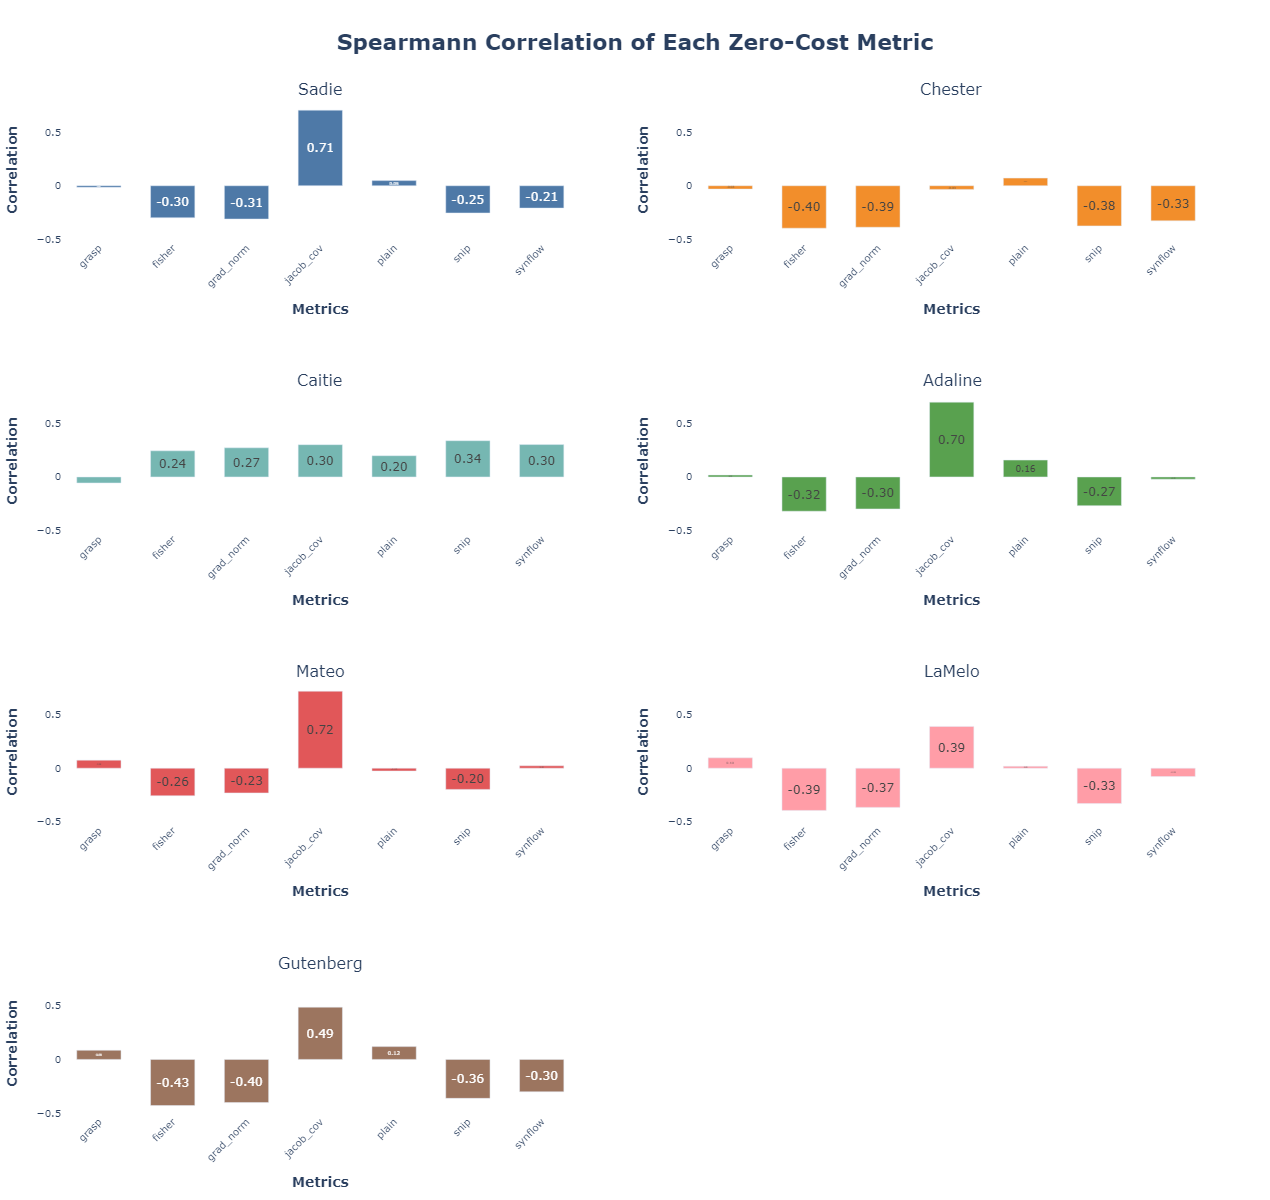

In [9]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Create subplots with a 4x2 grid
fig = sp.make_subplots(
    rows=4, cols=2, 
    subplot_titles=corr_dfs.columns,
    horizontal_spacing=0.10,  # Add spacing between subplots
    vertical_spacing=0.15
)

# Defining a refined color palette for the bars
colors = ['#4E79A7', '#F28E2B', '#76B7B2', '#59A14F', '#E15759', '#FF9DA7', '#9C755F', '#EDC948']

# Adding traces for each column and displaying the scores inside each bar
for i, column in enumerate(corr_dfs.columns):
    row = i // 2 + 1  # Adjust row based on 4 rows and 2 columns layout
    col = i % 2 + 1   # Adjust column based on 2 columns
    fig.add_trace(
        go.Bar(
            x=corr_dfs.index, 
            y=corr_dfs[column], 
            name=column, 
            marker_color=colors[i % len(colors)],  # Cycle through colors
            showlegend=False,  # Hide individual legends
            text=corr_dfs[column],  # Display the score values
            textposition='inside',  # Position the text inside the bars
            texttemplate='%{text:.2f}',  # Format the text to 2 decimal places
            insidetextanchor='middle',  # Center the text within the bars
            width=0.6  # Adjust bar width to avoid clutter
        ),
        row=row, col=col
    )

# Fix the y-axis range between -0.5 and 0.8 for all subplots
for i, column in enumerate(corr_dfs.columns):
    row = i // 2 + 1  # Adjust row
    col = i % 2 + 1   # Adjust column
    fig.update_yaxes(range=[-0.5, 0.8], row=row, col=col)

# Update layout with professional design elements
fig.update_layout(
    height=1200,  # Increase height for better visualization
    width=800,  # Adjust width for 2-column layout
    title_text="<b>Spearmann Correlation of Each Zero-Cost Metric</b>",  # Make title bold
    title_font_size=22,  # Increase title font size
    title_x=0.5,  # Center the title
    font=dict(size=12),  # Adjust font size for axis labels and tick marks
    margin=dict(t=100, b=40, l=60, r=60),  # Adjust margins for balanced spacing
    paper_bgcolor='white',  # Set a clean white background
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot background
)

# Customize the axis titles and tick labels for better readability
fig.update_xaxes(title_text="<b>Metrics</b>", tickangle=-45, tickfont=dict(size=10))
fig.update_yaxes(title_text="<b>Correlation</b>", tickfont=dict(size=10))

# Show plot
fig.show()


In [26]:
corr_df

,grasp,fisher,grad_norm,jacob_cov,plain,snip,synflow,dataset
0,0.027921,-0.389183,-0.363203,0.315912,-0.215401,-0.327441,-0.078879,LaMelo


In [27]:
corr_df

,grasp,fisher,grad_norm,jacob_cov,plain,snip,synflow,dataset
0,0.009081,-0.394204,-0.364255,0.25582,-0.10449,-0.324191,-0.078566,LaMelo


In [10]:
fig.write_image("regressors/zcost_corr.svg",format="SVG")

In [11]:
fig.write_image("regressors/zcost_corr.png",format="PNG")